In [2]:
import os
# os.environ['DEVICE_ID'] = '6'
import csv
import numpy as np

import mindspore as ms
from mindspore import nn
from mindspore import context
from mindspore import dataset
from mindspore.train.callback import LossMonitor
from mindspore.common.api import ms_function
from mindspore.ops import operations as P

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

In [3]:
with open('iris.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[40:60]) # 打印部分数据

[['5.0', '3.5', '1.3', '0.3', 'Iris-setosa'], ['4.5', '2.3', '1.3', '0.3', 'Iris-setosa'], ['4.4', '3.2', '1.3', '0.2', 'Iris-setosa'], ['5.0', '3.5', '1.6', '0.6', 'Iris-setosa'], ['5.1', '3.8', '1.9', '0.4', 'Iris-setosa'], ['4.8', '3.0', '1.4', '0.3', 'Iris-setosa'], ['5.1', '3.8', '1.6', '0.2', 'Iris-setosa'], ['4.6', '3.2', '1.4', '0.2', 'Iris-setosa'], ['5.3', '3.7', '1.5', '0.2', 'Iris-setosa'], ['5.0', '3.3', '1.4', '0.2', 'Iris-setosa'], ['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor'], ['6.4', '3.2', '4.5', '1.5', 'Iris-versicolor'], ['6.9', '3.1', '4.9', '1.5', 'Iris-versicolor'], ['5.5', '2.3', '4.0', '1.3', 'Iris-versicolor'], ['6.5', '2.8', '4.6', '1.5', 'Iris-versicolor'], ['5.7', '2.8', '4.5', '1.3', 'Iris-versicolor'], ['6.3', '3.3', '4.7', '1.6', 'Iris-versicolor'], ['4.9', '2.4', '3.3', '1.0', 'Iris-versicolor'], ['6.6', '2.9', '4.6', '1.3', 'Iris-versicolor'], ['5.2', '2.7', '3.9', '1.4', 'Iris-versicolor']]


In [4]:
label_map = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
}

X = np.array([[float(x) for x in s[:-1]] for s in data[:100]], np.float32)
Y = np.array([[label_map[s[-1]]] for s in data[:100]], np.float32)

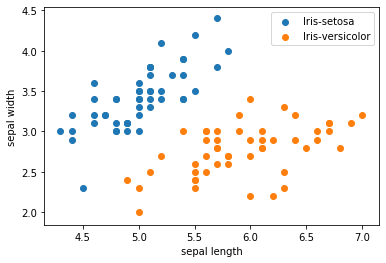

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(X[:50, 0], X[:50, 1], label='Iris-setosa')
plt.scatter(X[50:, 0], X[50:, 1], label='Iris-versicolor')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

In [6]:
train_idx = np.random.choice(100, 80, replace=False)
test_idx = np.array(list(set(range(100)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

In [7]:
XY_train = list(zip(X_train, Y_train))
ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y'])
# ds_train.set_dataset_size(80)
ds_train = ds_train.shuffle(buffer_size=80).batch(32, drop_remainder=True)

Text(0, 0.5, 'p')

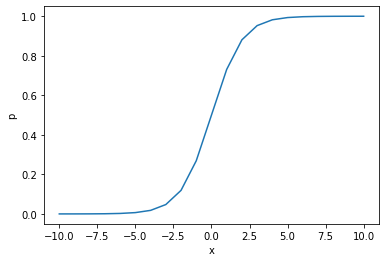

In [8]:
coor_x = np.arange(-10, 11, dtype=np.float32)
coor_y = nn.Sigmoid()(ms.Tensor(coor_x)).asnumpy()
plt.plot(coor_x, coor_y)
plt.xlabel('x')
plt.ylabel('p')

In [9]:
# 自定义Loss
class Loss(nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()
        self.sigmoid_cross_entropy_with_logits = P.SigmoidCrossEntropyWithLogits()
        self.reduce_mean = P.ReduceMean(keep_dims=False)
    def construct(self, x, y):
        loss = self.sigmoid_cross_entropy_with_logits(x, y)
        return self.reduce_mean(loss, -1)

net = nn.Dense(4, 1)
loss = Loss()
opt = nn.optim.SGD(net.trainable_params(), learning_rate=0.003)

In [10]:
model = ms.train.Model(net, loss, opt)
model.train(10, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], dataset_sink_mode=False)

epoch: 1 step: 2, loss is 0.6630135
epoch: 2 step: 2, loss is 0.5574384
epoch: 3 step: 2, loss is 0.51149625
epoch: 4 step: 2, loss is 0.45581928
epoch: 5 step: 2, loss is 0.5194427
epoch: 6 step: 2, loss is 0.36388376
epoch: 7 step: 2, loss is 0.34353644
epoch: 8 step: 2, loss is 0.30020967
epoch: 9 step: 2, loss is 0.3145944
epoch: 10 step: 2, loss is 0.28892735


In [11]:
x = model.predict(ms.Tensor(X_test)).asnumpy()
pred = np.round(1 / (1 + np.exp(-x)))
correct = np.equal(pred, Y_test)
acc = np.mean(correct)
print('Test accuracy is', acc)

Test accuracy is 1.0
